<a href="https://colab.research.google.com/github/eugeneyan/1-on-1s/blob/main/2_ft_fib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 11 21:06:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pip install -q transformers==4.37.2 accelerate bitsandbytes datasets peft watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.9 MB/s eta 0:00:00


In [3]:
%load_ext watermark
%watermark --conda -p torch,transformers,peft,datasets,sklearn

torch       : 2.2.1+cu121
transformers: 4.37.2
peft        : 0.10.0
datasets    : 2.19.1
sklearn     : 1.2.2

conda environment: n/a



In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import transformers
import time
import logging

from collections import Counter
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Trainer,
    BartForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    IntervalStrategy,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from typing import Dict, Optional, List
from sklearn.metrics import (average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt

In [5]:
# Set up logger
logger = logging.getLogger('2-ft-fib-only')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

logger.info('Running notebook to finetune FIB')

2024-05-11 21:08:16 - INFO - Running notebook to finetune FIB


In [6]:
torch.manual_seed(1368)

## Define model and tokenizer
- Note: Entailment = 2, Neutral = 1, Contradiction = 0
- https://huggingface.co/valhalla/distilbart-mnli-12-1

In [7]:
# Define model
model_id = 'valhalla/distilbart-mnli-12-1'
lora_model_id = 'lora-distilbart-mnli-12-1'

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Load FIB data

In [9]:
# Test loading into dataset
fib_files = {'train': '/content/drive/My Drive/fib-train.csv',
             'val': '/content/drive/My Drive/fib-val.csv',
             'test': '/content/drive/My Drive/fib-test.csv'}

fib_ds = load_dataset('csv', data_files=fib_files)
fib_ds = fib_ds.select_columns(['input', 'list_choices', 'label'])
fib_ds = fib_ds.rename_column('input', 'premise').rename_column('list_choices', 'hypothesis')

logger.info(f"Label distribution - Train: {Counter(fib_ds['train']['label'])}, Val: {Counter(fib_ds['val']['label'])}, Test: {Counter(fib_ds['test']['label'])}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2024-05-11 21:08:23 - INFO - Label distribution - Train: Counter({0: 350, 2: 350}), Val: Counter({0: 75, 2: 75}), Test: Counter({0: 75, 2: 75})


In [10]:
# Tokenize data in batch
def tokenize(row):
    return tokenizer(row['premise'], row['hypothesis'], truncation='only_first', padding='max_length', max_length=512)

fib_ds = fib_ds.map(tokenize, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [11]:
logger.info(f'FIB: {fib_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["attention_mask"]}')

2024-05-11 21:08:23 - INFO - FIB: If you leave your mobile phone somewhere do you worry you will not be able to check it?
If any of this sounds familiar, there is a chance you could be spending too much time on social networks.
An exclusive online Newsbeat poll suggests that a quarter of 15 to 18-year-olds in the UK feel happier online than they do in real life.
Dr Radha from The Surgery on Radio 1 has dealt with patients who have displayed "a lot of social anxiety" because they are using social networks too much.
"Being online can provoke a sense of 'I'm not good enough, everyone else is having an amazing life'," she explained.
"It doesn't give us a sense of reality and actually what you will find is most people are probably doing the same thing as you are."
The survey, carried out last month, also suggests a third of 15 to 18-year-olds have met someone in person they originally met through social media.
Dr Radha has said it is important people carefully consider what information they

## Set up model

In [12]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10
EVAL_STEPS=20
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [13]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [14]:
# Load model
model = BartForSequenceClassification.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

2024-05-11 21:08:29 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [15]:
# Configure lora
config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,  # Keep lora alpha constant (per https://arxiv.org/abs/2305.14314) as it is proportional to learning rate
    target_modules=['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2'],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model.enable_input_require_grads()
model = get_peft_model(model, config)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    trainable_prop = 100 * trainable_params / all_param

    logger.info(f"all params: {all_param:,} | trainable: {trainable_params:,} ({trainable_prop:.2f}%)")

print_trainable_parameters(model)

2024-05-11 21:08:30 - INFO - all params: 142,151,731 | trainable: 3,981,360 (2.80%)


In [17]:
# Preprocess only logits to save memory
def preprocess_logits_for_metrics(logits, labels):
    """
    Returns the probability of contradiction (aka factual inconsistency aka hallucination)
    """
    # Exclude dim = 1 on the logits, compute softmax, and get prob of the 0 label (i.e., contradiction)
    probs = F.softmax(logits[0][:, [0, 2]], dim=1)[:, 0]
    return probs

# Compute multiple metrics at once
def compute_metrics(eval_pred: transformers.EvalPrediction) -> Dict[str, float]:
    labels = eval_pred.label_ids
    probs = eval_pred.predictions
    probs_thresholded = np.where(probs >= 0.80, 1, 0)  # Assign score > 0.8 = 1 (aka contradiction)

    # Update labels so 2 (entailment) is now 0, and 0 (contradiction) is now 1 because we want to focus on the latter
    labels = np.where(labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    # Compute metrics
    pr_auc = average_precision_score(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    recall = recall_score(labels, probs_thresholded)
    precision = precision_score(labels, probs_thresholded)

    return {'prauc': pr_auc, 'rocauc': roc_auc, 'recall': recall, 'precision': precision}

In [18]:
# Custom trainer to evaluate on multiple datasets
# See Trainer implementation: https://github.com/huggingface/transformers/blob/v4.31.0/src/transformers/trainer.py#L225
# See updates needed: https://github.com/huggingface/transformers/issues/20565
class CustomTrainer(Trainer):

    def __init__(self, eval_before_train=True, *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.eval_before_train = eval_before_train

    def train(self, resume_from_checkpoint=None, trial=None, **kwargs):
        metrics = None
        if self.eval_before_train:
            self.state.global_step = 0
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        # ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    logger.info(f'Step 0 metrics: {metrics}')
                    for key, value in metrics.items():
                        self.log({key: value})
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)
            self.eval_before_train = False

        # Call the original train method
        super(CustomTrainer, self).train(resume_from_checkpoint, trial, **kwargs)

    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        multiple=False,
    ) -> Dict[str, float]:
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else self.evaluation_loop
        output = eval_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )

        total_batch_size = self.args.eval_batch_size * self.args.world_size

        self.log(output.metrics)

        # self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)
        if not multiple:
            self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)

        self._memory_tracker.stop_and_update_metrics(output.metrics)

        return output.metrics

    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None and isinstance(self.eval_dataset, dict):
            # handle dictionary of datasets logic here
            # for this example, let's just return the 'fib' dataset dataloader
            eval_dataset = self.eval_dataset['set']
        return super().get_eval_dataloader(eval_dataset)


    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss

            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

In [19]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='/content/drive/My Drive/Colab Notebooks/fib-only',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    evaluation_strategy='steps',
    eval_steps=EVAL_STEPS,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_rocauc',
    greater_is_better=True,
    load_best_model_at_end=True,
)

In [20]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=fib_ds['train'],
#     eval_dataset={'fib': fib_ds['val']},
#     compute_metrics=compute_metrics,
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics
# )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=fib_ds['train'],
    eval_dataset={'fib': fib_ds['val']},  # Provide our eval as a dict
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


## Check evals before finetuning

In [21]:
fib_ds['val']

Dataset({
    features: ['premise', 'hypothesis', 'label', 'input_ids', 'attention_mask'],
    num_rows: 150
})

In [22]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

In [23]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def visualize_preds(y, y_pred, model_name):
    df = pd.DataFrame({'label': y, 'pred_proba': y_pred})

    # Compute ROCAUC metrics
    rocauc = roc_auc_score(df['label'], df['pred_proba'])
    fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
    baseline = np.sum(df['label']) / len(df)

    # Compute PRAUC metrics
    prauc = average_precision_score(df['label'], df['pred_proba'])
    prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

    # Split into consistent and inconsistent for prob distribution
    inconsistent = df[df['label'] == 1].reset_index(drop=True)
    consistent = df[df['label'] == 0].reset_index(drop=True)
    js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

    # Set up plots
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(13, 3), tight_layout=True)
    title_font_size = 10
    fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

    # Plot ROC
    ax0.grid()
    ax0.plot(fpr, tpr, label='ROC')
    ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate')
    ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
    ax0.legend()

    # Plot PRAUC
    ax1.grid()
    ax1.plot(rec, prec, label='PRAUC')
    ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim((-0.1, 1.1))
    ax1.set_ylim((-0.1, 1.1))
    ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot Precision & Recall
    ax2.grid()
    ax2.plot(thresholds, prec[1:], color='red', label='Precision')
    ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
    ax2.invert_xaxis()
    ax2.set_xlabel('Thresholds (1.0 - 0.0)')
    ax2.set_ylabel('Precision / Recall')
    ax2.set_xlim((1.1, -0.1))
    ax2.set_ylim((-0.1, 1.1))
    ax2.legend()
    ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot prob distribution
    ax3.grid()
    ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.set_xlabel('Prob of inconsistent')
    ax3.set_ylabel('Density')
    ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
    ax3.legend()

    plt.show()


def compute_metrics_per_threshold(y, y_pred, thresholds=[0.95, 0.90, 0.95, 0.80, 0.75, 0.70, 0.65, 0.60]):
    for threshold in thresholds:
        preds = (y_pred >= threshold).astype(int)

        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        logger.info(f'Threshold: {threshold:.2f} - Recall: {recall:.2f}, Precision: {precision:.2f}')

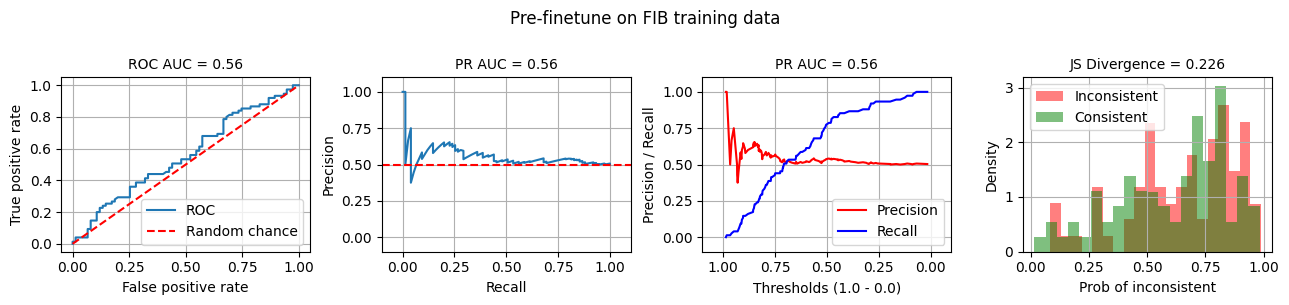

2024-05-11 21:08:35 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 21:08:35 - INFO - Threshold: 0.90 - Recall: 0.15, Precision: 0.61
2024-05-11 21:08:35 - INFO - Threshold: 0.95 - Recall: 0.04, Precision: 0.75
2024-05-11 21:08:35 - INFO - Threshold: 0.80 - Recall: 0.35, Precision: 0.58
2024-05-11 21:08:35 - INFO - Threshold: 0.75 - Recall: 0.44, Precision: 0.57
2024-05-11 21:08:35 - INFO - Threshold: 0.70 - Recall: 0.51, Precision: 0.51
2024-05-11 21:08:35 - INFO - Threshold: 0.65 - Recall: 0.55, Precision: 0.51
2024-05-11 21:08:35 - INFO - Threshold: 0.60 - Recall: 0.61, Precision: 0.52


In [24]:
visualize_preds(fib_val_labels, fib_val_preds, 'Pre-finetune on FIB training data')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

## Start finetuning

In [25]:
trainer.train()

2024-05-11 21:08:38 - INFO - Step 0 metrics: {'eval_fib_loss': 2.76171875, 'eval_fib_prauc': 0.5611561212032896, 'eval_fib_rocauc': 0.5572444444444445, 'eval_fib_recall': 0.3466666666666667, 'eval_fib_precision': 0.5777777777777777}


Step,Training Loss,Validation Loss,Fib Loss,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
20,1.371800,No log,0.854492,0.582430,0.579378,0.066667,0.625000
40,0.758400,No log,0.712891,0.602025,0.605600,0.040000,0.750000
60,0.682700,No log,0.681152,0.616943,0.632444,0.053333,0.800000
80,0.671400,No log,0.668945,0.640272,0.649244,0.040000,0.750000
100,0.664500,No log,0.662598,0.650347,0.658400,0.040000,0.750000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

## Check evals after finetuning

In [26]:
def eval_fib(dataset, split='val'):
    # Get predictions
    fib_preds = trainer.predict(fib_ds[split])[0]

    # Get labels and update them so entailment = 0 and contradiction = 1
    fib_labels = np.array(fib_ds[split]['label'])
    fib_labels = np.where(fib_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    visualize_preds(fib_labels, fib_preds, f'Post-finetune on FIB training data ({split})')
    compute_metrics_per_threshold(fib_labels, fib_preds)

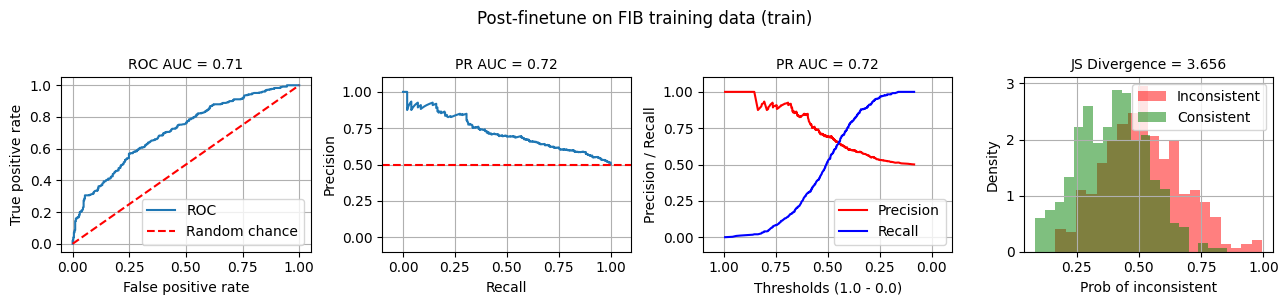

2024-05-11 21:13:45 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 1.00
2024-05-11 21:13:45 - INFO - Threshold: 0.90 - Recall: 0.01, Precision: 1.00
2024-05-11 21:13:45 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 1.00
2024-05-11 21:13:45 - INFO - Threshold: 0.80 - Recall: 0.04, Precision: 0.88
2024-05-11 21:13:45 - INFO - Threshold: 0.75 - Recall: 0.08, Precision: 0.91
2024-05-11 21:13:45 - INFO - Threshold: 0.70 - Recall: 0.13, Precision: 0.92
2024-05-11 21:13:45 - INFO - Threshold: 0.65 - Recall: 0.20, Precision: 0.86
2024-05-11 21:13:45 - INFO - Threshold: 0.60 - Recall: 0.30, Precision: 0.85


In [27]:
eval_fib(fib_ds, 'train')

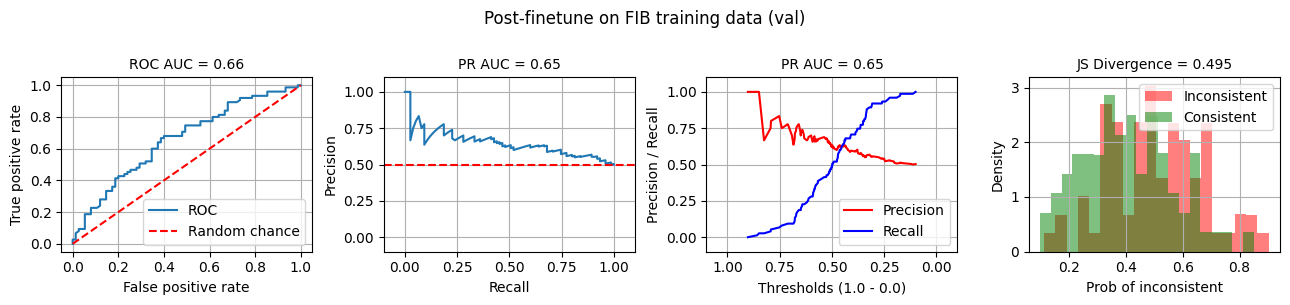

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-05-11 21:13:48 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-05-11 21:13:48 - INFO - Threshold: 0.90 - Recall: 0.01, Precision: 1.00
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-05-11 21:13:48 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-05-11 21:13:48 - INFO - Threshold: 0.80 - Recall: 0.04, Precision: 0.75
2024-05-11 21:13:48 - INFO - Threshold: 0.75 - Recall: 0.08, Precision: 0.75
2024-05-11 21:13:48 - INFO - Thre

In [28]:
eval_fib(fib_ds, 'val')

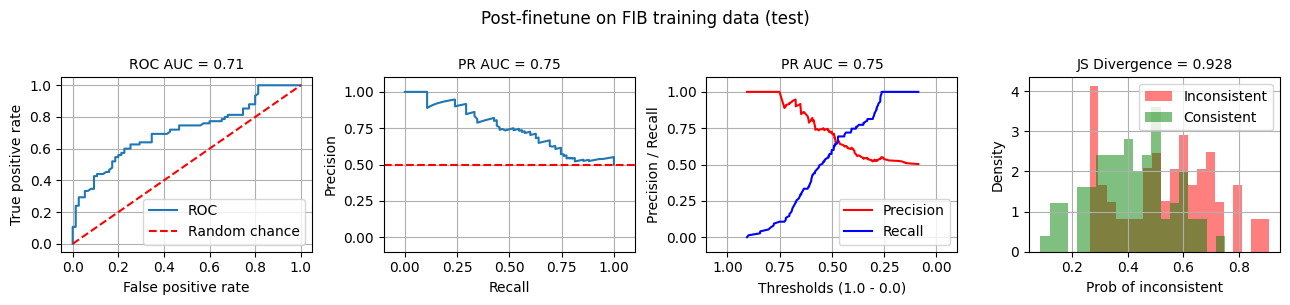

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-05-11 21:13:52 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-05-11 21:13:52 - INFO - Threshold: 0.90 - Recall: 0.01, Precision: 1.00
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-05-11 21:13:52 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-05-11 21:13:52 - INFO - Threshold: 0.80 - Recall: 0.07, Precision: 1.00
2024-05-11 21:13:52 - INFO - Threshold: 0.75 - Recall: 0.11, Precision: 0.89
2024-05-11 21:13:52 - INFO - Thre

In [29]:
eval_fib(fib_ds, 'test')